## pre-process for training

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
ADMISSIONS_CDiff_preprocess = pd.read_csv("./data/dataframes/admissions_cdiff_preprocess_feature_scaled.csv",index_col=0)

ADMISSIONS_CDiff_preprocess.drop(columns=["SUBJECT_ID","HADM_ID"],inplace=True)

ADMISSIONS_CDiff_preprocess.drop(columns=["NEWBORN"],inplace=True)

ADMISSIONS_CDiff_preprocess.head()

,ELECTIVE,EMERGENCY,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,TRANSFER FROM OTHER HEALT,...,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps,ages,LOS,target
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-0.237072,-0.323032,1.376425,0.119097,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,-0.503778,0.430710,0.588919,1.532958,1
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,-0.414876,-0.215355,-1.254031,0.207916,1
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.059268,0.000000,0.918148,-0.032561,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.325974,0.753742,0.576515,0.532619,1


In [4]:
admissions_cdiff_preprocess_shuffled_df = ADMISSIONS_CDiff_preprocess.sample(frac=1).reset_index(drop=True)

In [5]:
#tree regressions
X_tree = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns != 'target']
y_tree = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns == 'target']

In [6]:
#logistic regression
X_logreg = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns != 'target']
y_logreg = admissions_cdiff_preprocess_shuffled_df.loc[:, admissions_cdiff_preprocess_shuffled_df.columns == 'target']

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [8]:
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_logreg, y_logreg, test_size=0.3, random_state=0)

In [13]:
logistic_regressor = LogisticRegression(C=0.5,penalty='l1',class_weight='balanced',max_iter=100)
logistic_regressor.fit(X_train_logreg.values, y_train_logreg["target"].values)
y_pred_logreg = logistic_regressor.predict(X_test_logreg)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
roc_auc_score(y_test_logreg, y_pred_logreg)

0.7105457091956092

Out of the box, the logistic regressor does pretty good!

In [15]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.3, random_state=0)

In [16]:
random_forest_clf=RandomForestClassifier(n_estimators=100,max_depth=3,class_weight='balanced')
random_forest_clf.fit(X_train_tree.values,y_train_tree["target"].values)
y_pred_tree=random_forest_clf.predict(X_test_tree)

In [17]:
roc_auc_score(y_test_tree, y_pred_tree)

0.6815230784189645

Interesting, the logistic regressor performs as well as the random forest classifier

In [18]:
from imblearn.under_sampling import RandomUnderSampler as UnderSampler

We need to balance the data ourselves to use gradient boosting in scikit-learn

In [19]:
sampler = UnderSampler()
X_tree_balanced, y_tree_balanced = sampler.fit_sample(X_train_tree.values,y_train_tree["target"].values)

In [20]:
random_forest_gb_clf=GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,max_depth=3)
random_forest_gb_clf.fit(X_tree_balanced,y_tree_balanced)
y_pred_gb_tree=random_forest_gb_clf.predict(X_test_tree)

In [21]:
roc_auc_score(y_test_tree, y_pred_gb_tree)

0.6942993481158908

Interesting, the logistic regressor performs as well as the gradient-boosted random forest classifier

### CROSS-VALIDATE GRADIENT BOOST CLASSIFIER/LOGISTIC REGRESSION

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform
from sklearn import linear_model, datasets
import joblib

**Logistic Regressor**

In [24]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = [0.01,0.03,0.1,0.3,1,3]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

Use RandomizedSearchCV random search of these hyperparameters

In [30]:
logistic = linear_model.LogisticRegression()
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=12, cv=5, verbose=0, n_jobs=-1)

In [31]:
best_model = clf.fit(X_train_logreg.values, y_train_logreg["target"].values)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.01


Use GridSearchCV to finer hyperparameter search

In [34]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.08, 0.09,0.01,0.02, 0.03,0.1, 0.3, 1]}]

scores = ['precision_macro', 'recall_macro','roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced',max_iter=100), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train_logreg.values, y_train_logreg["target"].values)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_logreg, clf.predict(X_test_logreg)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision_macro



/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

Best parameters set found on development set:

{'C': 0.03}

Grid scores on development set:

0.528 (+/-0.003) for {'C': 0.08}
0.528 (+/-0.003) for {'C': 0.09}
0.526 (+/-0.002) for {'C': 0.01}
0.527 (+/-0.005) for {'C': 0.02}
0.528 (+/-0.004) for {'C': 0.03}
0.528 (+/-0.003) for {'C': 0.1}
0.528 (+/-0.003) for {'C': 0.3}
0.528 (+/-0.002) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     14151
           1       0.07      0.68      0.12       399

    accuracy                           0.73     14550
   macro avg       0.53      0.71      0.48     14550
weighted avg       0.96      0.73      0.82     14550


# Tuning hyper-parameters for recall_macro



/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best parameters set found on development set:

{'C': 0.03}

Grid scores on development set:

0.707 (+/-0.023) for {'C': 0.08}
0.708 (+/-0.020) for {'C': 0.09}
0.702 (+/-0.022) for {'C': 0.01}
0.708 (+/-0.037) for {'C': 0.02}
0.715 (+/-0.035) for {'C': 0.03}
0.709 (+/-0.020) for {'C': 0.1}
0.706 (+/-0.019) for {'C': 0.3}
0.705 (+/-0.012) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     14151
           1       0.07      0.68      0.12       399

    accuracy                           0.73     14550
   macro avg       0.53      0.71      0.48     14550
weighted avg       0.96      0.73      0.82     14550


# Tuning hyper-parameters for roc_auc



/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-pa

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.789 (+/-0.015) for {'C': 0.08}
0.789 (+/-0.015) for {'C': 0.09}
0.775 (+/-0.019) for {'C': 0.01}
0.782 (+/-0.019) for {'C': 0.02}
0.785 (+/-0.017) for {'C': 0.03}
0.789 (+/-0.015) for {'C': 0.1}
0.788 (+/-0.013) for {'C': 0.3}
0.786 (+/-0.010) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     14151
           1       0.07      0.67      0.12       399

    accuracy                           0.74     14550
   macro avg       0.53      0.71      0.49     14550
weighted avg       0.96      0.74      0.83     14550




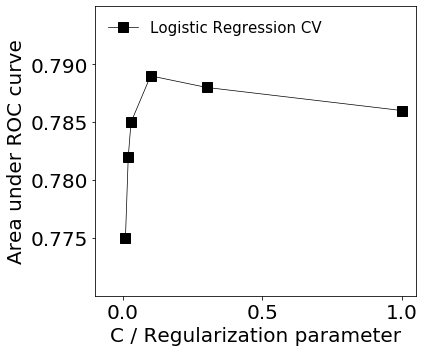

In [41]:
plt.figure()
plt.plot([0.01,0.02,0.03,0.1,0.3,1],[0.775,0.782,0.785,0.789,0.788,0.786], c='k',lw=0.7,marker="s",ms=10,label='Logistic Regression CV')
plt.xticks([0.0,0.5, 1.0],fontsize=20)
plt.yticks([0.775,0.78,0.785,0.79],fontsize=20)
plt.xlim([-0.1, 1.05])
plt.ylim([0.77, 0.795])
plt.xlabel('C / Regularization parameter',fontsize=20)
plt.ylabel('Area under ROC curve',fontsize=20)
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
plt.legend(frameon=False,loc="upper left",fontsize=15)
plt.tight_layout()
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.savefig('./week_4/Logistic_Regression_CV.jpg')
plt.show()

Cross-validation shows we can use any of the above values for C -- they all show the same performance

**Gradient-boosted Random Forest Classifier**

In [42]:
# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': [3, 5, 10, 15]}]

scores = ['precision_macro', 'recall_macro','roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.2,n_estimators=25), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_tree_balanced, y_tree_balanced)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_tree, clf.predict(X_test_tree)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision_macro

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.708 (+/-0.041) for {'max_depth': 3}
0.699 (+/-0.046) for {'max_depth': 5}
0.687 (+/-0.037) for {'max_depth': 10}
0.668 (+/-0.031) for {'max_depth': 15}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.68      0.80     14151
           1       0.06      0.71      0.11       399

    accuracy                           0.68     14550
   macro avg       0.52      0.69      0.46     14550
weighted avg       0.96      0.68      0.78     14550


# Tuning hyper-parameters for recall_macro

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.709 (+/-0.038) for {'max_depth': 3}
0.702 (+/-0.048) for {'max_depth': 5}
0.687 (+/-0.033) f

Max depth of 3 is as good as any.  In a gradient-boosted random forest the product of the number of trees (n_estimators) and the learning rate should be constant across the cross-validation set.  I've made a table below showing the results of the cross-validation for various values of the learning rate and the maximum depth of the tree.

In [43]:
roc_auc_df = pd.DataFrame(index=[0.01,0.03,0.1,0.2],columns=[3,5,10,15])

In [44]:
roc_auc_df.iloc[0] = [0.78,0.77,0.75,0.711]
roc_auc_df.iloc[1] = [0.78,0.77,0.75,0.72]
roc_auc_df.iloc[2] = [0.77,0.77,0.75,0.72]
roc_auc_df.iloc[3] = [0.78,0.76,0.75,0.72]

In [45]:
roc_auc_df

,3,5,10,15
0.01,0.78,0.77,0.75,0.711
0.03,0.78,0.77,0.75,0.72
0.10,0.77,0.77,0.75,0.72
0.20,0.78,0.76,0.75,0.72


## ROC Curve for optimal parameters 
### Logistic Regressor (C = 0.03, n_iter = 100)
### Gradient-boosted random forest (learning rate=0.1,max_depth=3,n_estimators=50)

In [46]:
#C=0.03-1,auc is 0.78
logistic_regressor_cv = LogisticRegression(C=0.03,penalty='l1',class_weight='balanced',max_iter=100)
logistic_regressor_cv.fit(X_train_logreg.values, y_train_logreg["target"].values)
y_pred_logreg = logistic_regressor_cv.predict(X_test_logreg)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [47]:
random_forest_gb_auc_clf=GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,max_depth=3)
random_forest_gb_auc_clf.fit(X_tree_balanced,y_tree_balanced)
y_pred_gb_tree=random_forest_gb_auc_clf.predict(X_test_tree)

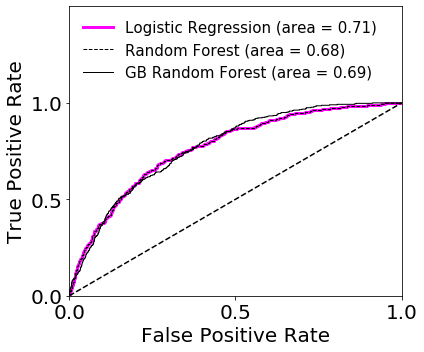

In [49]:
logit_roc_auc_logreg = roc_auc_score(y_test_logreg, y_pred_logreg)
logit_roc_auc_rf = roc_auc_score(y_test_tree, y_pred_tree)
logit_roc_auc_gbrf = roc_auc_score(y_test_tree, y_pred_gb_tree)
fpr,tpr, thresholds = roc_curve(y_test_logreg, logistic_regressor_cv.predict_proba(X_test_logreg)[:,1])
fpr2,tpr2,thresholds2 = roc_curve(y_test_tree, random_forest_clf.predict_proba(X_test_tree)[:,1])
fpr3,tpr3, thresholds3 = roc_curve(y_test_tree, random_forest_gb_auc_clf.predict_proba(X_test_tree)[:,1])
plt.figure()
plt.plot(fpr, tpr, c='magenta',lw=3.0,label='Logistic Regression (area = %0.2f)' % logit_roc_auc_logreg)
plt.plot(fpr,tpr,c='black',lw=1.0,ls='--',label='Random Forest (area = %0.2f)' % logit_roc_auc_rf)
plt.plot(fpr3, tpr3, c='black',lw=1.0,label='GB Random Forest (area = %0.2f)' % logit_roc_auc_gbrf)
#for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
#    plt.annotate(np.round(txt,2), (x, y-0.06),fontsize=15)
plt.plot([0, 1], [0, 1],'k--')
plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.yticks([0.0,0.5,1.0],fontsize=20)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.5])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
plt.legend(frameon=False,loc="upper left",fontsize=15)
plt.tight_layout()
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.savefig('./week_4/Logistic_Regression_RF_GBRF_AUCROC.jpg')
plt.show()

Logistic Regression, Random Forest, and Gradient-Boosted Random Forest perform the same

## Precision-Recall Curves

We also want a sense of how precise (TP/(TP+FP)) our model and the recall (TP/(TP+FN))

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

In [51]:
sampler2 = UnderSampler(sampling_strategy=0.5)
X_tree_balanced2, y_tree_balanced2 = sampler2.fit_sample(X_train_tree.values,y_train_tree["target"].values)
sampler10 = UnderSampler(sampling_strategy=0.1)
X_tree_balanced10, y_tree_balanced10 = sampler10.fit_sample(X_train_tree.values,y_train_tree["target"].values)

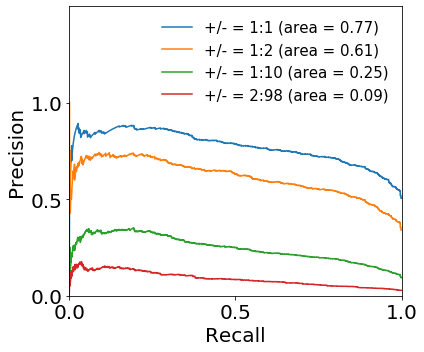

In [75]:
#logit_roc_auc = roc_auc_score(y_test_tree, y_pred_gb_tree)
precision_train,recall_train, thresholds_train = precision_recall_curve(y_tree_balanced, logistic_regressor_cv.predict_proba(X_tree_balanced)[:,1])
precision2,recall2, thresholds2 = precision_recall_curve(y_tree_balanced2, logistic_regressor_cv.predict_proba(X_tree_balanced2)[:,1])
precision10,recall10, thresholds10 = precision_recall_curve(y_tree_balanced10, logistic_regressor_cv.predict_proba(X_tree_balanced10)[:,1])
precision,recall, thresholds = precision_recall_curve(y_test_logreg, logistic_regressor_cv.predict_proba(X_test_logreg)[:,1])

plt.figure()
plt.plot(recall_train, precision_train, label='+/- = 1:1 (area = %0.2f)' % metrics.auc(recall_train,precision_train))
plt.plot(recall2, precision2, label='+/- = 1:2 (area = %0.2f)' % metrics.auc(recall2,precision2))
plt.plot(recall10, precision10, label='+/- = 1:10 (area = %0.2f)' % metrics.auc(recall10,precision10))
plt.plot(recall, precision, label='+/- = 2:98 (area = %0.2f)' % metrics.auc(recall,precision))

#plt.plot([0, 1], [0, 1],'r--')
#for x, y, txt in zip(recall[::3000], precision[::3000], thresholds[::3000]):
#    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.5])
plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.yticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
#plt.title('Precision-Recall Curve')
plt.legend(loc="upper right",fontsize=15,frameon=False)
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout()
plt.savefig('./week_4/Logistic_regression_precision_recall_detection_limit.jpg')
plt.show()

In [58]:
import random
def random_classifier(frac_pos_class,num_targets):
    random_guess = [0]*num_targets
    for idx,i in enumerate(random_guess):
        x = random.uniform(0,1)
        if x >= (1-frac_pos_class):
            random_guess[idx] = 1
    return random_guess

In [54]:
y_test_logreg.shape

(14550, 1)

In [71]:
random_guess_2 = random_classifier(0.02,len(y_test_logreg))
random_guess_10 = random_classifier(0.1,len(y_tree_balanced10))
random_guess_50 = random_classifier(0.5,len(y_tree_balanced))

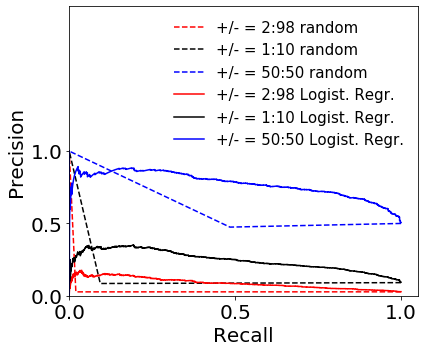

In [80]:
precision_train,recall_train, thresholds_train = precision_recall_curve(y_tree_balanced, logistic_regressor_cv.predict_proba(X_tree_balanced)[:,1])
precision_random_50,recall_random_50, thresholds_random_50 = precision_recall_curve(y_tree_balanced, random_guess_50)
precision_random_2,recall_random_2, thresholds_random_2 = precision_recall_curve(y_test_logreg, random_guess_2)
precision,recall, thresholds = precision_recall_curve(y_test_logreg, logistic_regressor_cv.predict_proba(X_test_logreg)[:,1])
precision_random_10,recall_random_10, thresholds_random_10 = precision_recall_curve(y_tree_balanced10, random_guess_10)
precision10,recall10, thresholds10 = precision_recall_curve(y_tree_balanced10, logistic_regressor_cv.predict_proba(X_tree_balanced10)[:,1])
plt.figure()
plt.plot(recall_random_2, precision_random_2, c='r', ls = '--', label='+/- = 2:98 random')
plt.plot(recall_random_10, precision_random_10, c='k', ls= '--', label='+/- = 1:10 random')
plt.plot(recall_random_50, precision_random_50, c='b',ls= '--', label='+/- = 50:50 random')
plt.plot(recall, precision, c='r',label='+/- = 2:98 Logist. Regr.')
plt.plot(recall10, precision10,c='k', label='+/- = 1:10 Logist. Regr.')
plt.plot(recall_train, precision_train,c='b', label='+/- = 50:50 Logist. Regr.')
#plt.plot([0, 1], [0, 1],'r--')
#for x, y, txt in zip(recall[::3000], precision[::3000], thresholds[::3000]):
 #   plt.annotate(np.round(txt,2), (x, y-0.04))
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 2.0])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks([0,0.5,1.0],fontsize=20)
plt.yticks([0,0.5,1.0],fontsize=20)
#plt.title('Precision-Recall Curve')
plt.legend(fontsize=15,frameon=False)
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout()
plt.savefig('./week_4/Logistic_regression_precision_recall_vs_random.jpg')
plt.show()

The area under the precision-recall curves decreases as the class-imbalance increases.  Nevertheless, our model consistently performs better than a random classifier. 

## Feature Importance in Logistic Regressor

In [81]:
features_names = list(X_train_tree.columns)
logistic_regression_coeffs = logistic_regressor_cv.coef_

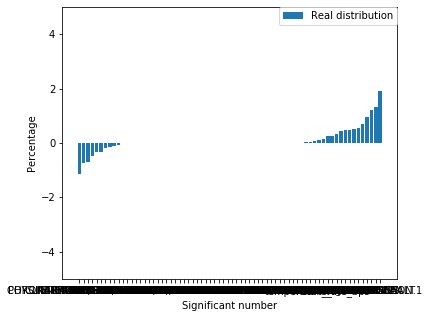

In [82]:
import operator
x = dict(zip(features_names,logistic_regression_coeffs[0]))
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
features = [item[0] for item in sorted_x]
coeffs = [item[1] for item in sorted_x]


plt.bar(features, coeffs , label="Real distribution")

plt.ylim(-5,5)
plt.ylabel ('Percentage')
plt.xlabel ('Significant number')
#plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

In [83]:
sorted_x

[('CORONARY ARTERY DISEASE', -1.1288832628589467),
 ('PHYS REFERRAL/NORMAL DELI', -0.72169023128718),
 ('ELECTIVE', -0.7000908151571384),
 ('CHEST PAIN', -0.4762815932911932),
 ('OTHER', -0.34549641635480527),
 ('CLINIC REFERRAL/PREMATURE', -0.33850395933254707),
 ('EMERGENCY ROOM ADMIT', -0.19715705012293974),
 ('INTRACRANIAL HEMORRHAGE', -0.15133328248499506),
 ('HISPANIC', -0.092722308634423),
 ('URGENT', -0.058843501662313856),
 ('** INFO NOT AVAILABLE **', 0.0),
 ('HMO REFERRAL/SICK', 0.0),
 ('TRANSFER FROM HOSP/EXTRAM', 0.0),
 ('TRANSFER FROM SKILLED NUR', 0.0),
 ('TRSF WITHIN THIS FACILITY', 0.0),
 ('ASIAN', 0.0),
 ('WHITE', 0.0),
 ('CONGESTIVE HEART FAILURE', 0.0),
 ('ABDOMINAL PAIN', 0.0),
 ('ALTERED MENTAL STATUS', 0.0),
 ('PANCREATITIS', 0.0),
 ('GASTROINTESTINAL BLEED', 0.0),
 ('LOWER GI BLEED', 0.0),
 ('LOWER GASTROINTESTINAL BLEED', 0.0),
 ('S/P FALL', 0.0),
 ('DYSPNEA', 0.0),
 ('GI BLEED', 0.0),
 ('TRANSIENT ISCHEMIC ATTACK', 0.0),
 ('DEHYDRATION', 0.0),
 ('RESPIRATORY D

In [84]:
log_reg_feature_importance = pd.DataFrame({'feature':['Colitis','Sepsis','Fever','Diarrhea','Hypotension','Length of Stay','Age'],'weight':[1.63,1.4,1.1,1.03,1.03,0.7,0.49]})

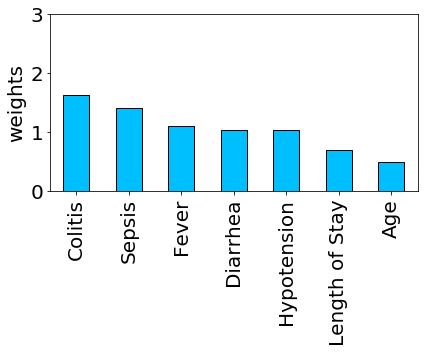

In [85]:
log_reg_feature_importance.plot(kind='bar',legend=None,x='feature',y='weight',facecolor='deepskyblue',edgecolor='black');
plt.xticks(fontsize=20)
plt.xlabel('');
plt.yticks([0.0,1.0,2.0,3.0],fontsize=20);
plt.ylabel('weights',fontsize=20);
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout();
#plt.savefig("./week_4/feature_importance_log_reg.jpg")

## PROBABILITY DISTRIBUTION OF POSTIVE AND NEGATIVE CASES

In [86]:
logistic_regressor = joblib.load("./models/logistic_regressor_scaled_features.mdl")

In [87]:
cdiff_pos_preprocess = ADMISSIONS_CDiff_preprocess.loc[ADMISSIONS_CDiff_preprocess['target'] == 1]
cdiff_neg_preprocess = ADMISSIONS_CDiff_preprocess.loc[ADMISSIONS_CDiff_preprocess['target'] == 0]
cdiff_pos_preprocess_inputs = cdiff_pos_preprocess.loc[:,cdiff_pos_preprocess.columns != 'target']
cdiff_neg_preprocess_inputs = cdiff_neg_preprocess.loc[:,cdiff_neg_preprocess.columns != 'target']

In [88]:
cdiff_pos_probs = logistic_regressor.predict_proba(cdiff_pos_preprocess_inputs.to_numpy())[:,1]
cdiff_neg_probs = logistic_regressor.predict_proba(cdiff_neg_preprocess_inputs.to_numpy())[:,1]

In [89]:
cdiff_pos_probs = pd.DataFrame({'C. diff. positive':cdiff_pos_probs})
cdiff_neg_probs = pd.DataFrame({'C. diff. negative':cdiff_neg_probs})

In [90]:
cdiff_pos_probs['C. diff. positive'].to_csv("./data/p_dists/cdiff_pos_prob_scaled_features.csv",index=False)
cdiff_neg_probs['C. diff. negative'].to_csv("./data/p_dists/cdiff_neg_prob_scaled_features.csv",index=False)

/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/home/walter/software/anaconda3/envs/cdiff/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [94]:
import numpy as np
import matplotlib.lines as mlines

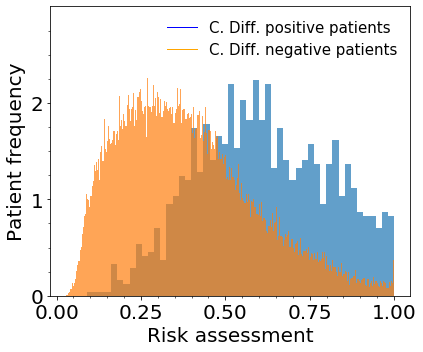

In [95]:
ax=plt.gca()
ax.set_xticks(np.arange(0.0,1.0,0.05),minor=True)
ax.set_yticks(np.arange(0.0,3.0,0.25),minor=True)
cdiff_pos_probs.hist(bins=50,density=True,grid=False,ax=ax,alpha=0.7);
cdiff_neg_probs.hist(bins=300,density=True,grid=False,ax=ax,alpha=0.7);
plt.title(label="");
cdiff_pos = mlines.Line2D([], [], c='b', lw=1.0, label = 'C. Diff. positive patients');
cdiff_neg = mlines.Line2D([], [], c='orange', lw=1.0, label='C. Diff. negative patients');
plt.legend(handles=[cdiff_pos,cdiff_neg],frameon=False,fontsize=15);
plt.xlabel("Risk assessment",fontsize=20);
plt.ylabel("Patient frequency",fontsize=20);
plt.xticks([0.0,0.25,0.5,0.75,1.0],fontsize=20);
plt.yticks([0.0,1.0,2.0],fontsize=20);
plt.ylim([0,3.0]);
plt.rcParams["figure.figsize"] = [6.0,5.0];
plt.tight_layout();
#plt.savefig("./week_4/cdiff_populations.jpg")

In [ ]:
a